In [ ]:
# Importing the required libraries
import pandas as pd

# Importing CSV
import csv

# Other libraries that could be used
import numpy as np
# Visualisation libraries
import matplotlib.pyplot as plt
%matplotlib inline

# Disable warnings 
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# List Drive contents
!ls '/content/drive/My Drive/EYE' # <- change here

Group14.csv  Group30.csv  train.csv


In [ ]:
# Directory to Drive where csv is
import os
change_path = '/content/drive/My Drive/EYE' # <- change here
os.chdir(change_path)
root_path = os.getcwd()
print(root_path)

/content/drive/My Drive/EYE


In [ ]:
# Delimiter
data_file_delimiter = ','

# The max column count a line in the file could have
largest_column_count = 0

# Loop the data lines
with open('train.csv', 'r') as temp_f: # <- edit filename
  # Read the lines
  lines = temp_f.readlines()

  for l in lines:
    # Count the column count for the current line
    column_count = len(l.split(data_file_delimiter)) + 1

    # Set the new most column count
    largest_column_count = column_count if largest_column_count < column_count else largest_column_count

# Close file
temp_f.close()

# Generate column names (will be 0, 1, 2, ..., largest_column_count - 1)
column_names = [i for i in range(0, largest_column_count)]

# Read CSV-data and print first rows
df= pd.read_csv('train.csv', header=None, delimiter=data_file_delimiter, names=column_names, index_col=0) # <- edit filename
dt = df.copy()
dt.head()

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,...,43987,43988,43989,43990,43991,43992,43993,43994,43995,43996,43997,43998,43999,44000,44001,44002,44003,44004,44005,44006,44007,44008,44009,44010,44011,44012,44013,44014,44015,44016,44017,44018,44019,44020,44021,44022,44023,44024,44025,44026
0,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
s26,False,-739.34,1223.31,-739.85,1228.46,-740.35,1228.46,-740.35,1228.46,-739.85,1228.46,-739.85,1233.61,-740.85,1238.76,-741.86,1249.07,-741.86,1249.07,-740.85,1249.07,-739.85,1259.37,-740.85,1259.37,-741.35,1254.22,-740.85,1259.37,-738.84,1264.52,-737.33,1269.67,-737.33,1274.82,-737.33,1274.82,-737.84,1269.67,-738.34,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
s32,True,-12.31,202.49,-12.31,202.49,-11.96,202.49,-11.96,203.80,-12.31,203.80,-11.96,203.14,-11.28,201.83,-11.28,201.18,-11.62,201.18,-11.62,202.49,-11.62,204.45,-11.62,205.77,-11.62,205.11,-12.31,203.80,-12.99,203.80,-13.33,205.11,-12.99,205.77,-12.99,206.42,-13.33,205.77,-13.67,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
s8,False,-664.47,-806.21,-665.24,-807.56,-666.01,-808.91,-666.40,-806.21,-666.01,-802.16,-665.63,-802.16,-666.01,-803.51,-666.40,-804.86,-665.63,-804.86,-664.86,-804.86,-665.24,-806.21,-666.40,-807.56,-666.78,-807.56,-666.40,-807.56,-665.63,-807.56,-665.63,-810.26,-666.01,-810.26,-666.40,-810.26,-666.78,-811.61,-667.17,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
s7,False,-44.01,67.51,-44.42,68.40,-44.83,67.51,-44.01,66.62,-43.20,66.62,-43.20,65.74,-44.01,64.85,-44.42,63.07,-44.01,64.85,-44.42,63.07,-37.07,23.06,-37.47,23.06,-37.88,22.17,-37.88,21.28,-37.47,21.28,-36.66,22.17,-36.25,23.06,-35.84,22.17,-35.84,22.17,-35.84,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
s5,True,636.58,-105.04,636.58,-103.52,635.56,-103.52,634.54,-103.52,633.01,-102.01,632.49,-102.01,633.52,-104.28,635.05,-107.31,636.07,-108.07,636.58,-107.31,636.07,-106.55,636.07,-105.04,636.07,-103.52,636.07,-102.77,635.05,-102.77,636.07,-103.52,637.09,-103.52,637.60,-102.77,637.60,-103.52,637.60,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
import math

# I-VT algorithm based on: https://github.com/PwQt/EyeMovementAlgorithmsAnalysis/blob/master/IVT.py

# Degrees per second
FIXATION_VELOCITY_THRESHOLD = float(100)
# ms
FIXATION_DURATION_THRESHOLD = float(100)

# @return:
# groupedFixationData: [FixationMiddleX_inUnits, FixationMiddleY_inUnits, FixationDurationInMS]
# fixations: list containing individual fixation points in units [x1, y1, x2, ...]
# saccades: list containing individual saccade points in units [x1, y1, x2, ...]
# testLength: duration of this test in ms
def calculateIvtAlgorithm(case):
  fixations = []
  saccades = []
  velocity = 0
  testLength = 0
  i = 1
  # Go through points for specific case
  while True:
    # If last in the list or nan
    if (i + 4 > len(case)) or (str(case[i + 2]) == 'nan'):
      testLength += 2
      # Velocity between current and next, pointnextX - x, nextY - y
      velocity = velocityBetweenPoints(case[i + 2], case[i], case[i + 3], case[i + 1])
      if velocity < FIXATION_VELOCITY_THRESHOLD:
        fixations.append(case[i])
        fixations.append(case[i + 1])
        fixations.append(case[i + 2])
        fixations.append(case[i + 3])
      break

    # Normal case
    velocity = velocityBetweenPoints(case[i+2], case[i], case[i+3], case[i+1])
    testLength += 1

    if (velocity < FIXATION_VELOCITY_THRESHOLD):
      fixations.append(case[i])
      fixations.append(case[i + 1])
    else:
      saccades.append(case[i])
      saccades.append(case[i + 1])
    i += 2
  
  i = 0
  combineFixationsArray = []
  groupedFixationData = []
  while i < len(fixations) - 2:
    velocity = velocityBetweenPoints(fixations[i + 2], fixations[i], fixations[i + 3], fixations[i + 1])
    if velocity < FIXATION_VELOCITY_THRESHOLD:
      combineFixationsArray.append(fixations[i])
      combineFixationsArray.append(fixations[i + 1])
    else:
      aLen = len(combineFixationsArray)
      if aLen != 0 and aLen/2 > FIXATION_DURATION_THRESHOLD:
        # Calculate middle-point of fixation
        sumX = 0
        sumY = 0
        for j in range(0, aLen, 2):
          sumX += combineFixationsArray[j]
          sumY += combineFixationsArray[j + 1]

        sumX /= aLen/2
        sumY /= aLen/2

        temp = [sumX, sumY, aLen/2]

        groupedFixationData.append(temp)
        del combineFixationsArray[:]
    i += 2

  return groupedFixationData, fixations, saccades, testLength

def velocityBetweenPoints(nextX, x, nextY, y):
  userFromScreenMM = 450
  # Length between points in mm
  length = math.sqrt(math.pow(unitXtoMM(nextX-x), 2) + math.pow(unitYtoMM(nextY-y), 2))

  # Degrees between points
  radian = math.tan(length/userFromScreenMM)
  degree = math.degrees(radian)

  # Return degrees change (degree per second)
  change = degree*1000
  return change

def unitXtoMM(units):
  return (units*(195/1400))

def unitYtoMM(units):
  return (units*(113/1400))
  
def calculateSD(row, tempMFD, tempMSA):
  # MFD_SD_true, MFD_SD_false, MFD_SD_overall
  MFD_true_sum = 0
  MFD_false_sum = 0
  MFD_overall_sum = 0
  # tempMFD = [[allTrues], [allFalses]]
  for trueValue in tempMFD[0]:
    MFD_true_sum += math.pow(trueValue-row[1], 2)
    MFD_overall_sum += math.pow(trueValue-row[9], 2)
  for falseValue in tempMFD[1]:
    MFD_false_sum += math.pow(falseValue-row[3], 2)
    MFD_overall_sum += math.pow(trueValue-row[9], 2)
  row[2] = math.sqrt(MFD_true_sum/len(tempMFD[0]))
  row[4] = math.sqrt(MFD_false_sum/len(tempMFD[1]))
  row[10] = math.sqrt(MFD_overall_sum/(len(tempMFD[0])+len(tempMFD[1])))

  # MSA_SD_true, MSA_SD_false, MSA_SD_overall
  MSA_true_sum = 0
  MSA_false_sum = 0
  MSA_overall_sum = 0
  # tempMSA = [[allTrues], [allFalses]]
  for trueValue in tempMSA[0]:
    MSA_true_sum += math.pow(trueValue-row[5], 2)
    MSA_overall_sum += math.pow(trueValue-row[11], 2)
  for falseValue in tempMSA[1]:
    MSA_false_sum += math.pow(falseValue-row[7], 2)
    MSA_overall_sum += math.pow(trueValue-row[11], 2)
  row[6] = math.sqrt(MSA_true_sum/len(tempMSA[0]))
  row[8] = math.sqrt(MSA_false_sum/len(tempMSA[1]))
  row[12] = math.sqrt(MSA_overall_sum/(len(tempMSA[0])+len(tempMSA[1])))

  return row

Test number: 62 subject: s10 is known: False and its length in ms: 1733
groupedFixationData for this test:
 [[735.5244067796607, 417.4810169491526, 236.0], [97.50309392265184, -27.776906077348052, 181.0], [-250.53960912052085, -379.8862214983714, 307.0], [252.63063888888868, -174.8162222222224, 360.0], [-272.59420074349447, -388.12081784386595, 269.0]]


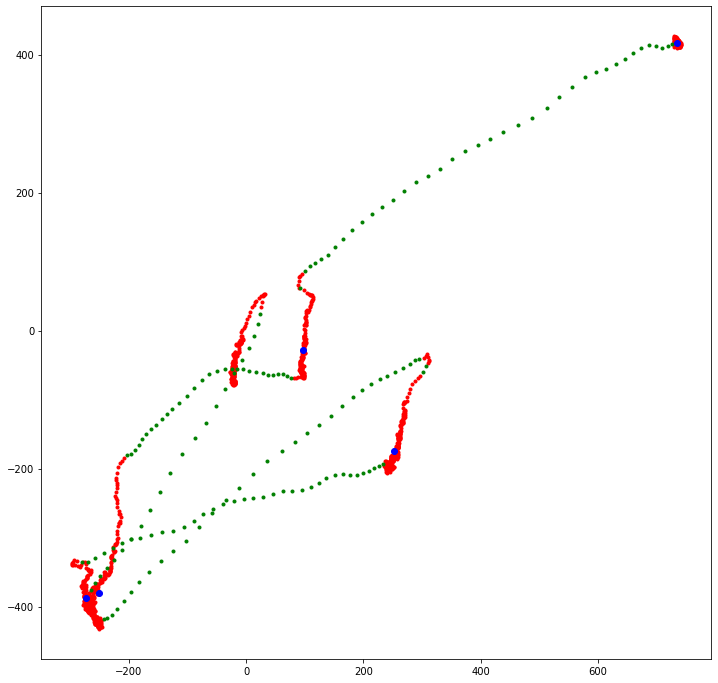

In [ ]:
# Subject for group 14: 2,8,10,14,16,22,28,30
groupSubjects = ['s2', 's8', 's10', 's14', 's16', 's22', 's28', 's30']

# Lists for test data
groupedFixationData = []
fixations = []
saccades = []
row = []
testLength = 0

# Each index has data of one test
allSubjectTests = []

# Calculate fixations, saccades and other data related to them for each subject
for subject in groupSubjects:
  subjectAll = dt.loc[[subject]]
  # All tests for this subject
  for i in range(subjectAll.shape[0]):
    # One test for this subject
    row = subjectAll.iloc[i].to_numpy(copy=True).tolist()
    # Fixation data for one test of this subject
    groupedFixationData, fixations, saccades, testLength = calculateIvtAlgorithm(row)
    # Add test to table | row[0]=True/False
    allSubjectTests.append([subject, row[0], groupedFixationData, fixations, saccades, testLength])

# Used in visuals and CSV. FormattedTestData structure is the following:
# [ 0         1            2           3              4               5            6           7                8              9               10              11              12        ]
# ['s3', "MFD_true", "MFD_SD_true", "MFD_false", "MFD_SD_false", "MSA_true", "MSA_SD_true", "MSA_false", "MSA_SD_false", "MFD_overall", "MFD_overall_SD", "MSA_overall", "MSA_overall_SD"]
# ['s5', "MFD_true", "MFD_SD_true", "MFD_false", "MFD_SD_false", "MSA_true", "MSA_SD_true", "MSA_false", "MSA_SD_false", "MFD_overall", "MFD_overall_SD", "MSA_overall", "MSA_overall_SD"]
# ... 
tempS = ''
tempC = ''
prevS = 's2'
tempFixationData = []
tempMFD = [[], []] # [[allTrues], [allFalses]]
tempMSA = [[], []] # [[allTrues], [allFalses]]
formattedTestData = []
tempLen = 0
# All values for visualisation later on
AllMFD = [[], []] # [[allTrues], [allFalses]]
AllMSA = [[], []] # [[allTrues], [allFalses]]
for i, test in enumerate(allSubjectTests):
  tempS = test[0] # Subject
  tempC = test[1] # Condition True/False
  tempFixationData = test[2] # groupedFixationData

  # If not same subject then calculate MFD&MSA
  if tempS != prevS or i == len(allSubjectTests)-1:
    tempRow = [prevS, '', '', '', '', '', '', '', '', '', '', '', '']
    # Calculate
    # MFD: true, false and overall (in ms)
    tempRow[1] = sum(tempMFD[0])/len(tempMFD[0])
    tempRow[3] = sum(tempMFD[1])/len(tempMFD[1])
    tempRow[9] = (sum(tempMFD[0])+sum(tempMFD[1])) / (len(tempMFD[0])+len(tempMFD[1]))
    # MSA: true, false and overall ()
    tempRow[5] = sum(tempMSA[0])/len(tempMSA[0])
    tempRow[7] = sum(tempMSA[1])/len(tempMSA[1])
    tempRow[11] = (sum(tempMSA[0])+sum(tempMSA[1])) / (len(tempMSA[0])+len(tempMSA[1]))
    # SD
    tempRow = calculateSD(tempRow, tempMFD, tempMSA)
    #print(tempRow)
    formattedTestData.append(tempRow)
    # For next subject
    prevS = tempS
    tempMFD = [[], []]
    tempMSA = [[], []]

  # MFD&MSA for test
  for i in range(len(tempFixationData)-1):
    # MSA
    if i <= (len(tempFixationData)-2):
      # Get as degrees by dividing with 1000 that is refresh rate of eye-tracker
      length = velocityBetweenPoints(tempFixationData[i+1][0], tempFixationData[i][0], tempFixationData[i+1][1], tempFixationData[i][1])/1000
      if tempC:
        tempMSA[0].append(length)
        AllMSA[0].append(length)
      else:
        tempMSA[1].append(length)
        AllMSA[1].append(length)
    # MFD
    if tempC:
      tempMFD[0].append(tempFixationData[i][2])
      AllMFD[0].append(tempFixationData[i][2])
    else:
      tempMFD[1].append(tempFixationData[i][2])
      AllMFD[1].append(tempFixationData[i][2])

# Rounding
for dataLine in formattedTestData:
  for i in range(1, len(dataLine)):
    value = round(dataLine[i], 2)
    dataLine[i] = value

# Creating and saving CSV into os.chdir(). 
row_list = ["subject_id", "MFD_true", "MFD_SD_true", "MFD_false", "MFD_SD_false", "MSA_true", "MSA_SD_true", "MSA_false", "MSA_SD_false", "MFD_overall", "MFD_overall_SD", "MSA_overall", "MSA_overall_SD"]
with open('Group14.csv', 'wt', newline='') as file:
  writer = csv.writer(file, delimiter=',', quotechar='|', quoting=csv.QUOTE_MINIMAL)
  writer.writerow(row_list)
  writer.writerows(formattedTestData)

# TESTING some test of some subject
testNum = 62 # From all the tests (good ones: 62, 82, 162)
groupedFixationData = allSubjectTests[testNum][2]
fixations = allSubjectTests[testNum][3]
saccades = allSubjectTests[testNum][4]
print('Test number:', testNum, 'subject:', allSubjectTests[testNum][0], 'is known:', allSubjectTests[testNum][1],  'and its length in ms:', allSubjectTests[testNum][5])
print('groupedFixationData for this test:\n', groupedFixationData)

# Fixation points of the test to own lists
fixationsX = []
fixationsY = []
for i in range(0, len(fixations)-1, 2):
  fixationsX.append(fixations[i])
  fixationsY.append(fixations[i+1])

# Points belonging to saccades of the test to own lists
saccadesX = []
saccadesY = []
for i in range(0, len(saccades)-1, 2):
  saccadesX.append(saccades[i])
  saccadesY.append(saccades[i+1])

# Grouped fixation points of the test to own lists
groupedFixationsX = []
groupedFixationsY = []
for row in groupedFixationData:
  groupedFixationsX.append(row[0])
  groupedFixationsY.append(row[1])

# Plot fixations of the test
# Coordinates are in units
plt.figure(figsize=(12, 12))
plt.plot(fixationsX, fixationsY, 'r.')
plt.plot(saccadesX, saccadesY, 'g.')
plt.plot(groupedFixationsX, groupedFixationsY, 'bo')
plt.show()

If you need only formatted test data, no need to run whole notebook.
Start here:

In [ ]:
# Read formatted testdata and print first rows
ftd= pd.read_csv('/content/drive/My Drive/EYE/Group14.csv', index_col=0) # edit
ftd

,MFD_true,MFD_SD_true,MFD_false,MFD_SD_false,MSA_true,MSA_SD_true,MSA_false,MSA_SD_false,MFD_overall,MFD_overall_SD,MSA_overall,MSA_overall_SD
subject_id,,,,,,,,,,,,
s2,246.23,101.14,252.37,99.04,8.06,6.59,7.83,4.57,250.30,60.55,7.91,5.04
s8,250.62,145.71,217.07,103.89,6.92,4.92,7.24,4.69,236.03,110.80,7.06,5.28
s10,233.81,73.79,238.90,98.47,5.92,3.52,7.37,5.01,238.36,96.98,7.22,3.31
s14,300.46,147.36,324.24,191.15,4.69,3.09,5.07,3.39,319.57,306.92,5.00,3.79
s16,260.92,94.74,268.73,142.76,5.17,3.42,4.40,2.61,266.17,54.94,4.65,2.41
s22,233.64,73.75,198.09,49.47,7.90,3.81,6.25,3.27,207.19,61.69,6.68,6.92
s28,224.55,83.78,230.16,108.40,5.91,8.23,5.39,6.99,228.85,82.56,5.51,4.20
s30,274.15,133.64,259.14,95.98,7.05,4.23,6.35,4.27,260.84,84.53,6.43,1.80


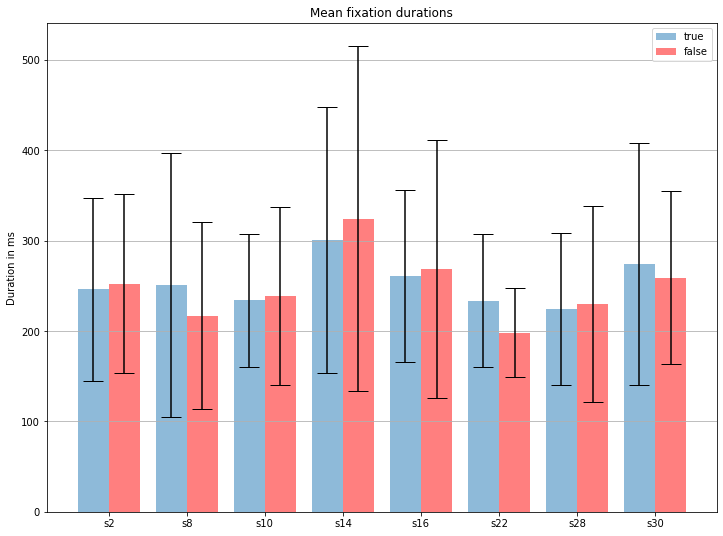

In [ ]:
### MFD PER CASE ###
samples = ftd.index.values

x_pos = np.arange(len(samples)) # x locations of the groups
width = 0.4       # the width of the bars

fig, ax = plt.subplots()
true = ax.bar(x_pos, ftd['MFD_true'], width, yerr=ftd['MFD_SD_true'], alpha=0.5, ecolor='black', capsize=10)
false = ax.bar(x_pos+width, ftd['MFD_false'], width, yerr=ftd['MFD_SD_false'], alpha=0.5, ecolor='black', capsize=10, color='r')

ax.set_ylabel('Duration in ms')
ax.set_xticks(x_pos+width/2)
ax.set_xticklabels(samples)
ax.set_title('Mean fixation durations')
ax.yaxis.grid(True)
ax.legend( (true[0], false[0]), ('true', 'false') )

fig.set_size_inches(12,9)
#plt.savefig('/content/drive/My Drive/EYE/MFD_per_case.png') # save plot
plt.show()

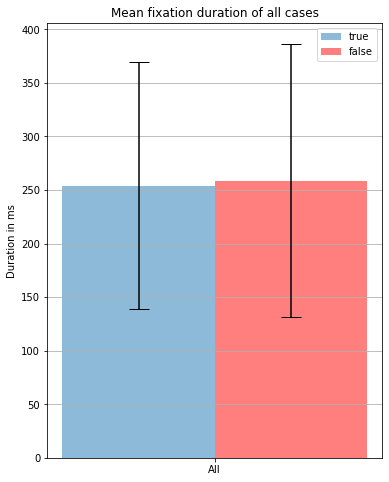

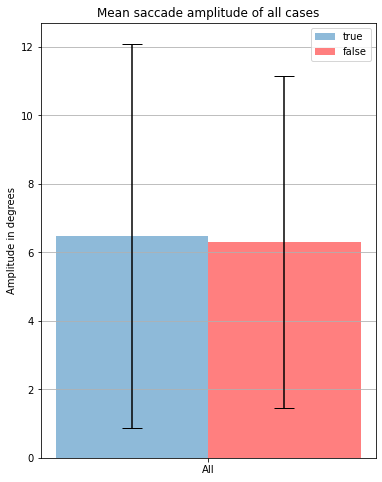

In [ ]:
### MFD AND MSA FOR ALL CASES ###

#AllMFD, AllMSA
#[[allTrues], [allFalses]]
#[[allTrues], [allFalses]]

#means
MFD_true_mean = sum(AllMFD[0]) / len(AllMFD[0])
MFD_false_mean = sum(AllMFD[1]) / len(AllMFD[1])
MSA_true_mean = sum(AllMSA[0]) / len(AllMSA[0])
MSA_false_mean = sum(AllMSA[1]) / len(AllMSA[1])

#SD's MFD
MFD_true_sum = 0
MFD_false_sum = 0
for trueValue in AllMFD[0]:
  MFD_true_sum += math.pow(trueValue-MFD_true_mean, 2)
for falseValue in AllMFD[1]:
  MFD_false_sum += math.pow(falseValue-MFD_false_mean, 2)
MFD_SD_true = math.sqrt(MFD_true_sum/len(AllMFD[0]))
MFD_SD_false = math.sqrt(MFD_false_sum/len(AllMFD[1]))

#SD's MSA
MSA_true_sum = 0
MSA_false_sum = 0
for trueValue in AllMSA[0]:
  MSA_true_sum += math.pow(trueValue-MSA_true_mean, 2)
for falseValue in AllMSA[1]:
  MSA_false_sum += math.pow(falseValue-MSA_false_mean, 2)
MSA_SD_true = math.sqrt(MSA_true_sum/len(AllMSA[0]))
MSA_SD_false = math.sqrt(MSA_false_sum/len(AllMSA[1]))

x_pos = np.arange(1) # x locations of the groups
width = 0.4 # the width of the bars

#plot MFD
fig, ax = plt.subplots()
true = ax.bar(x_pos, MFD_true_mean, width, yerr=MFD_SD_true, alpha=0.5, ecolor='black', capsize=10)
false = ax.bar(x_pos+width, MFD_false_mean, width, yerr=MFD_SD_false, alpha=0.5, ecolor='black', capsize=10, color='r')
ax.set_ylabel('Duration in ms')
ax.set_xticks(x_pos+width/2)
ax.set_xticklabels(["All"])
ax.set_title('Mean fixation duration of all cases')
ax.yaxis.grid(True)
ax.legend((true[0], false[0]),('true', 'false'))

fig.set_size_inches(6,8)
plt.show()

#plot MSA
fig, ax = plt.subplots()
true = ax.bar(x_pos, MSA_true_mean, width, yerr=MSA_SD_true, alpha=0.5, ecolor='black', capsize=10)
false = ax.bar(x_pos+width, MSA_false_mean, width, yerr=MSA_SD_false, alpha=0.5, ecolor='black', capsize=10, color='r')
ax.set_ylabel('Amplitude in degrees')
ax.set_xticks(x_pos+width/2)
ax.set_xticklabels(["All"])
ax.set_title('Mean saccade amplitude of all cases')
ax.yaxis.grid(True)
ax.legend((true[0], false[0]),('true', 'false'))

fig.set_size_inches(6,8)
#plt.savefig('/content/drive/My Drive/EYE/MFD_MSA_merged.png') # save plot, if you want to
plt.show()

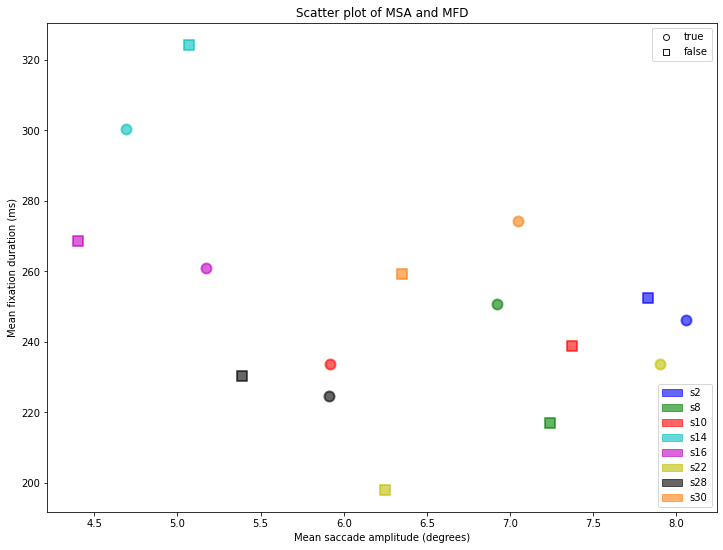

In [ ]:
import matplotlib.patches as mpatches

### SCATTER PLOT MSA x MFD ###
#ref https://matplotlib.org/tutorials/intermediate/legend_guide.html

samples = ftd.index.values  #[s2, s8, s10, s14, s16, s22, s28, s30]

fig, ax = plt.subplots()
sample_legend = [] #array for sample legends (used in ax.legend())

colors=['b','g','r','c','m','y','k','tab:orange']

truefalse = []

# plot points in loop (different color and shapes)
for i in range(0,len(samples)):
  ax.scatter(ftd['MSA_true'][i], ftd['MFD_true'][i], color=colors[i], alpha=0.6, marker='o', linewidths=2, s=100)
  ax.scatter(ftd['MSA_false'][i], ftd['MFD_false'][i], color=colors[i], alpha=0.6, marker='s', linewidths=2, s=100) #edgecolors='r'
  sample_legend.append(mpatches.Patch(color=colors[i], label=samples[i], alpha=0.6)) #legend for color/sample 


#legends for true and false
truefalse.append(ax.scatter([],[],color='k', label='true', alpha=0.9, marker='o', facecolors='w'))
truefalse.append(ax.scatter([],[],color='k', label='false', alpha=0.9, marker='s', facecolors='w'))
first_legend = ax.legend(handles=truefalse, loc='upper right')

#add first_legend
fig.gca().add_artist(first_legend)

# second legend for color/samples
ax.legend(handles=sample_legend, loc='lower right') #second_legend 

#info
ax.set_ylabel('Mean fixation duration (ms)')
ax.set_xlabel('Mean saccade amplitude (degrees)')
ax.set_title('Scatter plot of MSA and MFD')

fig.set_size_inches(12,9)
#plt.savefig('/content/drive/My Drive/EYE/MSA_MFD_scatterplot.png') # save plot
plt.show()

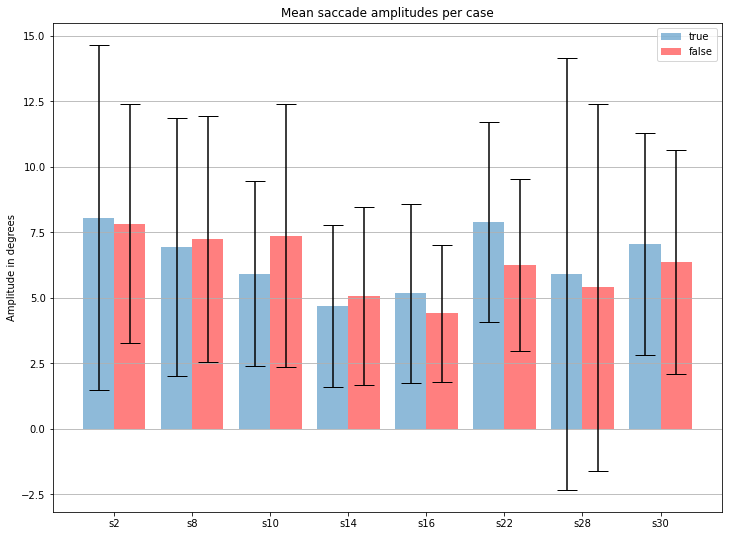

In [ ]:
### MSA PER CASE ###
samples = ftd.index.values

x_pos = np.arange(len(samples)) # x locations of the groups
width = 0.4       # the width of the bars

fig, ax = plt.subplots()
true = ax.bar(x_pos, ftd['MSA_true'], width, yerr=ftd['MSA_SD_true'], alpha=0.5, ecolor='black', capsize=10)
false = ax.bar(x_pos+width, ftd['MSA_false'], width, yerr=ftd['MSA_SD_false'], alpha=0.5, ecolor='black', capsize=10, color='r')

ax.set_ylabel('Amplitude in degrees')
ax.set_xticks(x_pos+width/2)
ax.set_xticklabels(samples)
ax.set_title('Mean saccade amplitudes per case')
ax.yaxis.grid(True)
ax.legend( (true[0], false[0]), ('true', 'false') )

fig.set_size_inches(12,9)
#plt.savefig('/content/drive/My Drive/EYE/MSA_per_case.png') # save plot
plt.show()